In [1]:
%pip install gymnasium[atari]
%pip install gymnasium[accept-rom-license]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 1.3.0
    Uninstalling Shimmy-1.3.0:
      Successfully uninstalled Shimmy-1.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.16.11 requires shimmy>=1.2.1, but you have shimmy 0.2.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 8.4 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=autorom_accept_rom_license-0.6.1-py3-none-any.whl size=446673 sha256=b3e28e1abe5ee084226326e82706b111f96f11984333cdd3aa1fa62604ebe211
  

In [2]:
from gymnasium import ObservationWrapper
from gymnasium.spaces import Box
import numpy as np
import cv2
from collections import deque
import gymnasium as gym
from matplotlib import pyplot as plt

class CropObservation(ObservationWrapper):
    def __init__(self, env, top=0, bottom=None, left=0, right=None):
        super().__init__(env)
        
        orig_shape = env.observation_space.shape
        orig_dtype = env.observation_space.dtype
        orig_h, orig_w = orig_shape[:2]
        c = orig_shape[2] if len(orig_shape) == 3 else 1

        self.top = max(0, top)
        self.bottom = min(orig_h, bottom) if bottom is not None else orig_h
        self.left = max(0, left)
        self.right = min(orig_w, right) if right is not None else orig_w

        assert self.top < self.bottom, "Некорректные границы: top >= bottom"
        assert self.left < self.right, "Некорректные границы: left >= right"

        self.observation_space = Box(
            low=0,
            high=255,
            shape=(self.bottom - self.top, self.right - self.left, c) if c > 1 else (self.bottom - self.top, self.right - self.left),
            dtype=orig_dtype
        )

    def observation(self, obs):
        return obs[self.top:self.bottom, self.left:self.right]

class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape=(84, 84)):
        super().__init__(env)
        self.shape = shape
        self.observation_space = gym.spaces.Box(
            low=0.0, 
            high=1.0, 
            shape=shape, 
            dtype=np.float32
        )

    def observation(self, obs):
        return cv2.resize(obs, self.shape, interpolation=cv2.INTER_NEAREST)

class GrayScaleObservation(ObservationWrapper):
    def __init__(self, env, keep_dim=True):
        super().__init__(env)
        self.keep_dim = keep_dim
        channels = 1 if keep_dim else None
        shape = (*self.observation_space.shape[:2], channels) if keep_dim \
            else self.observation_space.shape[:2]
        self.observation_space = Box(
            low=0,
            high=255,
            shape=shape,
            dtype=np.uint8
        )

    def observation(self, obs):
        gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        return np.expand_dims(gray, axis=-1) if self.keep_dim else gray

class FrameStack(gym.Wrapper):
    def __init__(self, env, k=4):
        super().__init__(env)
        self.k = k
        self.frames = deque([], maxlen=k)
        obs_shape = self.env.observation_space.shape

        self.observation_space = gym.spaces.Box(
            low=0, high=255,
            shape=(self.k, obs_shape[0], obs_shape[1]),
            dtype=np.uint8
        )

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.frames.clear()
        for _ in range(self.k):
            self.frames.append(obs)
        return self._get_obs(), info

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.frames.append(obs)
        return self._get_obs(), reward, done, truncated, info

    def _get_obs(self):
        return np.stack(self.frames, axis=0)

In [3]:
HEIGHT = 84
WIDTH = 84
N_STACK_FRAMES = 4

def make_env():
    env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")
    env = CropObservation(env, top=34, bottom=194, left=0, right=160)
    env = ResizeObservation(env, (HEIGHT, WIDTH))
    env = GrayScaleObservation(env, keep_dim=False)
    env = FrameStack(env, N_STACK_FRAMES)
    return env

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
import torch

BATCH_SIZE = 64
LR = 0.0001
GAMMA = 0.99
MEMORY_CAPACITY = 750000
MEMORY_START_SIZE = 75000
MEMORY_START_SIZE = MEMORY_START_SIZE if MEMORY_START_SIZE > BATCH_SIZE else BATCH_SIZE
Q_NETWORK_ITERATION = 20000
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")
NUM_ACTIONS = env.action_space.n
Q_THRESHOLD = 30.0

In [5]:
from torch import nn, optim
import numpy as np
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, in_channels=N_STACK_FRAMES, num_actions=NUM_ACTIONS):
        super(Net, self).__init__()

        inner_dim = 512
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        
        self.conv.apply(self.init_weights)

        conv_out_size = self._get_conv_output((in_channels, HEIGHT, WIDTH))

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, inner_dim),
            nn.ReLU(),
            nn.Linear(inner_dim, num_actions)
        )

        self.fc.apply(self.init_weights)

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def _get_conv_output(self, shape):
        dummy_input = torch.zeros(1, *shape)
        with torch.no_grad():
            conv_out = self.conv(dummy_input)
        return conv_out.numel()

    def init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(0.01)


class ExperienceReplay:
    def __init__(self, capacity):
        self.MEMORY_CAPACITY = capacity
        self.memory_counter = 0
        
        self.states = np.zeros((capacity, N_STACK_FRAMES, HEIGHT, WIDTH), dtype=np.uint8)
        self.next_states = np.zeros_like(self.states, dtype=np.uint8)
        self.actions = np.zeros((capacity,), dtype=np.int64)
        self.rewards = np.zeros((capacity,), dtype=np.float32)
        self.dones = np.zeros((capacity,), dtype=bool)

    def store_transition(self, state, action, reward, next_state, done):
        index = self.memory_counter % self.MEMORY_CAPACITY
        
        self.states[index] = state
        self.actions[index] = action
        self.rewards[index] = reward
        self.next_states[index] = next_state
        self.dones[index] = done
        
        self.memory_counter += 1

    def get_batch(self, batch_size):
        sample_index = np.random.choice(len(self), batch_size, replace=False)
        
        batch_state = torch.tensor(self.states[sample_index], dtype=torch.float32, device=DEVICE)
        batch_next_state = torch.tensor(self.next_states[sample_index], dtype=torch.float32, device=DEVICE)
        batch_action = torch.tensor(self.actions[sample_index], dtype=torch.long, device=DEVICE).unsqueeze(1)
        batch_reward = torch.tensor(self.rewards[sample_index], dtype=torch.float32, device=DEVICE).unsqueeze(1)
        batch_done = torch.tensor(self.dones[sample_index], dtype=torch.bool, device=DEVICE).unsqueeze(1)

        batch_state /= 255.0
        batch_next_state /= 255.0

        next_not_done_mask = (batch_done == 0).squeeze()

        return batch_state, batch_action, batch_reward, batch_next_state, next_not_done_mask

    def __len__(self):
        return self.memory_counter if self.memory_counter < self.MEMORY_CAPACITY else self.MEMORY_CAPACITY


class DQN:
    def __init__(self):
        super(DQN, self).__init__()
        self.possible_actions = list(range(0, NUM_ACTIONS))
        self.eval_net = Net().to(DEVICE)
        self.target_net = Net().to(DEVICE)

        self.buffer = ExperienceReplay(MEMORY_CAPACITY)

        self.learning_rate = LR
        self.optimizer = optim.Adam(self.eval_net.parameters(), lr=self.learning_rate)

    def get_action(self, state, epsilon, return_q_value=False):
        state = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        state /= 255.0

        with torch.no_grad():
            out = self.eval_net(state)
            action = out.argmax().item()
            q_value = out.max().item() 
    
        if np.random.random() < epsilon:
            action = np.random.choice(self.possible_actions, 1)[0]
    
        if return_q_value:
            return action, q_value
        else:
            return action

    def update(self, num_steps=10):
        total_loss = 0.0
        for _ in range(num_steps):
            batch_state, batch_action, batch_reward, batch_next_state, next_not_done_mask = self.buffer.get_batch(BATCH_SIZE)

            next_not_done_states = batch_next_state[next_not_done_mask]
            next_state_values = torch.zeros(BATCH_SIZE, device=DEVICE)
            q_out = self.eval_net(batch_state)
            q_a = q_out.gather(1, batch_action)
            with torch.no_grad():
                next_state_values[next_not_done_mask] = self.target_net(next_not_done_states).max(1)[0]
            target = batch_reward + GAMMA * next_state_values.unsqueeze(1)

            loss = F.smooth_l1_loss(q_a, target.detach())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
        if num_steps == 0:
            return 0
        return total_loss / num_steps

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
import imageio
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from typing import Optional

def test_agent(
        model_path: str = None,
        video_path: list[Optional[str]] = [],
        num_episodes: int = 3,
        prominence: float = 0.5
):

    env = make_env()
    dqn = DQN()
    if model_path:
        dqn.eval_net.load_state_dict(torch.load(model_path, map_location=DEVICE))
    dqn.eval_net.eval()

    episode_rewards = []
    episode_state_values = []
    episode_screenshots = []

    for episode in range(num_episodes):
        state, info = env.reset()
        print(info['lives'])
        episode_reward = 0.0
        state_values = []
        frames = []

        while True:
            action, state_value = dqn.get_action(state, epsilon=0.0, return_q_value=True)
            next_state, reward, terminated, truncated, info = env.step(action)

            state_values.append(state_value)

            last_frame = state[-1]
            if last_frame.dtype != np.uint8:
                    last_frame = (last_frame * 255).astype(np.uint8)  
            
            frames.append(last_frame)
            
            done = terminated or truncated
            episode_reward += reward
            
            state = next_state

            if done:
                break

        episode_rewards.append(episode_reward)
        episode_state_values.append(state_values)

        peaks, properties = find_peaks(state_values, prominence=0.9, distance=5)

        if len(peaks) > 4:
            peaks = peaks[np.argsort(properties["prominences"])[-4:]]

        episode_screenshots.append({peak: frames[peak] for peak in peaks})

        if video_path and len(video_path) > episode and video_path[episode]:
            
            imageio.mimsave(video_path[episode], frames, fps=8)
            print(f"Видео сохранено в {video_path[episode]}")

    env.close()

    return episode_rewards, episode_state_values, episode_screenshots

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-6-e452c8419a3f>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted b

5
Видео сохранено в /kaggle/working/play.mp4
Episode 0: Reward = 4.0
Average reward: 4.00


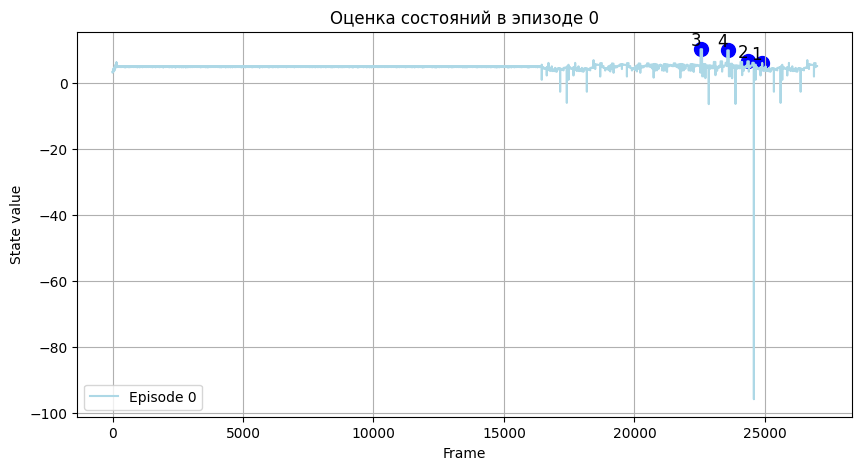

Пики для эпизода 0:


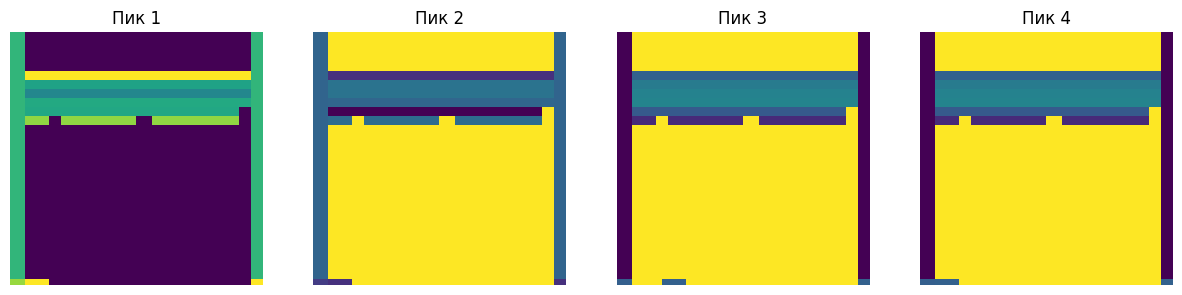

In [7]:
import IPython.display as display
import os
from IPython.display import HTML
import base64

def find_file(file_name):
    model_path = f"/kaggle/working/{file_name}"
    if os.path.exists(model_path):
        return model_path

    model_path_input = f"/kaggle/input/{file_name}"
    if os.path.exists(model_path_input):
        return model_path_input
    
    raise FileNotFoundError(f"Файл {file_name} не найден ни в /kaggle/working, ни в /kaggle/input.")

def show_video(video_path):
    video = open(video_path, "rb").read()
    video_b64 = base64.b64encode(video).decode()
    return HTML(f'<video width="400" controls><source src="data:video/mp4;base64,{video_b64}" type="video/mp4"></video>')

model_path = "/kaggle/input/target_net_last/pytorch/default/1/target_last (2).pt"
video_paths = ["/kaggle/working/play.mp4"]

rewards, state_values, peaks_screenshots = test_agent(
        model_path=model_path,
        num_episodes=1,
        video_path=video_paths
    )


for i, r in enumerate(rewards):
    print(f"Episode {i}: Reward = {r:.1f}")
print(f"Average reward: {np.mean(rewards):.2f}")


for i, q in enumerate(state_values):
    plt.figure(figsize=(10, 5))
    plt.plot(q, label=f"Episode {i}", color='lightblue')

    peaks = list(peaks_screenshots[i].keys())

    plt.scatter(peaks, np.array(q)[peaks], color='blue', marker='o', s=100)
    
    for j, peak in enumerate(peaks):
        plt.text(peak, q[peak], f'{j+1}', fontsize=12, verticalalignment='bottom', horizontalalignment='right')
    
    plt.xlabel("Frame")
    plt.ylabel("State value")
    plt.title(f"Оценка состояний в эпизоде {i}")
    plt.legend()
    plt.grid()
    plt.show()
    
    peaks_images = list(peaks_screenshots[i].values())

    if len(peaks_images) > 0:
        print(f"Пики для эпизода {i}:")
    
        fig, axes = plt.subplots(1, len(peaks_images), figsize=(15, 5))
        
        for j, screenshot in enumerate(peaks_images):
            axes[j].imshow(screenshot)
            axes[j].axis('off')
            axes[j].set_title(f"Пик {j + 1}")
    
        plt.show()

for video in video_paths:
    if os.path.exists(video):
        display.display(show_video(video))